In [1]:
import os
os.chdir("../")

import semiolog as slg

In [2]:
semiotic = slg.Cenematic("en_bnc")

SLG [I]: Checking config correctness... Config correct!


100%|██████████| 3/3 [00:00<00:00, 64.39it/s]

SLG [I]: Dataset loaded from disk (TXT files)
SLG [I]: Vocabulary loaded from disk


SLG [I]: nGrams loaded from disk (['2.json', '3.json'])


All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at models/en_bnc/paradigms/tf_model.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


SLG [I]: Paradigmatizer loaded from disk


In [3]:
from collections import defaultdict
import seaborn as sns
import networkx as nx
import graphviz as gv
from ipywidgets import interact

In [6]:
ng1keys = semiotic.vocab.ng1.keys[:37]
ng1_enc = semiotic.vocab.ng1.encode
ng1_dec = semiotic.vocab.ng1.decode
ng2keys = [l+r for l in ng1keys for r in ng1keys]
ng2_enc = {k: i for i,k in enumerate(ng2keys)}
ng2_dec = {i: k for i,k in enumerate(ng2keys)}
ng2 = semiotic.vocab.ng2
ng3 = semiotic.vocab.ng3

In [7]:
m_freq_1_1 = slg.util.build_term_context_matrix(
    terms = ng1keys,
    contexts = ng1keys,
    orthogonals = ng2.freq,
    normalizeQ = False)

Building oR Matrix...
Term-Context Matrix built in 0.01 secs.



In [8]:
m_freq_2_1 = slg.util.build_term_context_matrix(
    terms = ng2keys,
    contexts = ng1keys,
    orthogonals = ng3.freq,
    normalizeQ = False)

m_freq_1_2 = slg.util.build_term_context_matrix(
    terms = ng1keys,
    contexts = ng2keys,
    orthogonals = ng3.freq,
    normalizeQ = False)

Building oR Matrix...
Term-Context Matrix built in 0.31 secs.

Building oR Matrix...
Term-Context Matrix built in 0.03 secs.



In [10]:
m_pmi_1_1 = slg.util.build_pmi_matrix(
    m_freq_1_1,
    type = "spmi",
    alpha = .75,
    normalizeQ = False,
    )
m_pmi_2_1 = slg.util.build_pmi_matrix(
    m_freq_2_1,
    type = "spmi",
    alpha = .75,
    normalizeQ = False,
    )
m_pmi_1_2 = slg.util.build_pmi_matrix(
    m_freq_1_2,
    type = "spmi",
    alpha = .75,
    normalizeQ = False,
    )

Computing PMI Matrix...
Type: spmi
Smoothing (alpha): 0.75
Done
PMI Matrix built in 0.04 secs.
Done

Computing PMI Matrix...
Type: spmi
Smoothing (alpha): 0.75
Done
PMI Matrix built in 0.88 secs.
Done

Computing PMI Matrix...
Type: spmi
Smoothing (alpha): 0.75
Done
PMI Matrix built in 0.86 secs.
Done



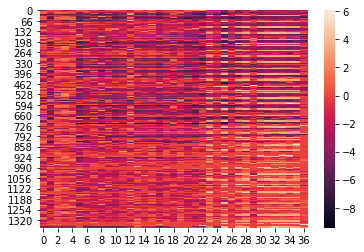

In [17]:
ax = sns.heatmap(m_pmi_2_1.toarray())

In [18]:
from numpy.linalg import svd

U11, s11, Vh11 = svd(m_pmi_1_1.toarray())
U21, s21, Vh21 = svd(m_pmi_2_1.toarray())
U12, s12, Vh12 = svd(m_pmi_1_2.toarray())

In [27]:
Tn = 1
T_sign = 1
U = U12
Vh = Vh12

type_L = sorted([(score*T_sign,term) for term, score in zip(ng2keys,U.T[Tn])], reverse=True)
type_R = sorted([(score*T_sign,context) for context, score in zip(ng1keys,Vh[Tn])], reverse=True)
slg.util.df([type_L[:15],type_R[:15]])

,0,1
0,"(0.1176161467910194, ea)","(0.057595854190598914, o)"
1,"(0.11560987956218127, eo)","(0.0497171619183494, y)"
2,"(0.11517942721326607, ei)","(0.048695617739912184, w)"
3,"(0.10223099592224591, ee)","(0.046444984913077865, e)"
4,"(0.05580086863023646, er)","(0.04624881469120688, b)"
5,"(0.05316183598239238, el)","(0.04510353056180412, r)"
6,"(0.04936329273817029, eu)","(0.04232514724044724, p)"
7,"(0.032709202572609015, en)","(0.04222141326701237, h)"
8,"(0.01629232086305748, ec)","(0.038661270150374245, t)"
9,"(0.013961681435435032, es)","(0.03817824862035397, i)"


In [20]:
from random import randint
sent = semiotic.corpus.train[randint(0,100000)]["text"]
# sent = "This is very good"
norm_text = semiotic.syntagmatic.tokenizer.normalizer.normalize_str(sent)
sent

'No problem at all ! ’'

In [28]:
pairs = set(slg.vocabulary.nGram.extract_ngrams(norm_text,2))
pair_scores = []
for pair in pairs:
    l = pair[0]
    r = pair[1]

    Tn_scores = []
    for type_n in range(s.size):
        Tl_score = U.T[type_n,ng1_enc[l]]
        Tr_score = Vh[type_n,ng1_enc[r]]
        Tn_score = Tl_score*Tr_score*s[type_n]
        signature = 1 if Tl_score>=0 else -1
        Tn_scores.append((Tn_score, type_n, signature))

    Tn_scores = sorted(Tn_scores,reverse=True)
    
    pair_scores.append((pair,Tn_scores[0]))

pair_scores_dict = dict(pair_scores)

segmentation_index = defaultdict(list)
for i, pair in enumerate(zip(norm_text, norm_text[1:])):
     segmentation_index[pair] += [i+1]
     
pair_scores_sorted = sorted(pair_scores,key=lambda x: x[1][0])

NameError: name 's' is not defined

In [46]:
G = nx.DiGraph()

to_segment = [(norm_text,(0,len(norm_text)))]

while len(to_segment)>0:
    for segment, offset in to_segment:
        segmentation_index = defaultdict(list)
        pairs = []
        for i, pair in enumerate(zip(segment, segment[1:])):
            segmentation_index[pair] += [i+1]
            pairs.append(pair)
        best_pair = sorted([(pair_scores_dict[pair][0], pair) for pair in pairs])[0][1]
        best_cut = segmentation_index[best_pair][0]
        G.add_edge((segment,offset), (segment[:best_cut],(offset[0],offset[0]+best_cut)))
        G.add_edge((segment,offset), (segment[best_cut:],(offset[0]+best_cut,offset[1])))
        
        to_segment = [x for x in G.nodes() if G.out_degree(x)==0 and G.in_degree(x)==1]
        to_segment = [seg for seg in to_segment if len(seg[0])>2]

In [47]:
seg_tree = G
seg_tree_graph = gv.Digraph(name="seg_tree")

tree_nodes_list = [(str(i), l) for l, i in list(seg_tree.nodes)]
for node in tree_nodes_list:
    seg_tree_graph.node(
        *node, color="white", fontsize="20", fontname="RobotoMono-Thin"
    )  # style="filled", color="grey")
seg_tree_graph.attr("edge", color="slategrey")
seg_tree_graph.edges([(str(p[1]), str(c[1])) for p, c in list(seg_tree.edges)])

@interact
def inter():
    return seg_tree_graph

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [18]:
leaves = sorted([x for x in G.nodes() if G.out_degree(x)==0 and G.in_degree(x)==1],key=lambda x:x[1])

In [23]:
types = defaultdict(list)
for pair, (score,type,sig) in pair_scores:
    types[(type,sig)] += [pair]

In [40]:
T_score, Tn, T_sign = pair_scores[5][1]

Tn = 2
T_sign = -1

print(Tn)
print(T_score)
type_L = sorted([(score*T_sign,term) for term, score in zip(ng1keys,U.T[Tn])], reverse=True)
type_R = sorted([(score*T_sign,context) for context, score in zip(contexts,Vh[Tn])], reverse=True)
slg.util.df([type_L[:15],type_R[:15]])

2
0.5260474510118539


,0,1
0,"(0.4605427191540503, £)","(0.381314355359129, x)"
1,"(0.4202153767657739, i)","(0.252462964886344, z)"
2,"(0.3350399850766742, a)","(0.217706247547869, n)"
3,"(0.2985543014977784, u)","(0.13380762678827388, v)"
4,"(0.2548599238155591, q)","(0.11233960681124366, q)"
5,"(0.1784602611996606, o)","(0.07863902062879022, k)"
6,"(0.16147716486912755, e)","(0.06797298700571675, g)"
7,"(0.01629349063798778, n)","(0.06213062726690899, d)"
8,"(0.012277300114925518, 1)","(0.037787645544902236, c)"
9,"(-0.0012166043905945528, 9)","(0.019863752149558746, l)"
